In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/har-dataset/Human_Activity_Recognition_Using_Smartphones_Data.csv


# 150 TCN + AM LR

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, Dropout, ReLU, Flatten, Add, Dense, Multiply,
    GlobalAveragePooling1D, Reshape
)
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
)
import time
import matplotlib.pyplot as plt
from tqdm import tqdm  # Progress bar

# Load dataset
df = pd.read_csv('/kaggle/input/har-dataset/Human_Activity_Recognition_Using_Smartphones_Data.csv')

# Encode target labels
label_encoder = LabelEncoder()
df['Activity'] = label_encoder.fit_transform(df['Activity'])

# Separate features and target
X = df.drop(columns=['Activity']).values
y = df['Activity'].values

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Feature Selection using LASSO
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_scaled, y)

# Extract absolute coefficients from the best alpha model
feature_importance = np.abs(lasso.coef_)

# Get feature names
feature_names = df.drop(columns=["Activity"]).columns

# Select top 150 features based on importance
sorted_idx = np.argsort(feature_importance)[::-1][:150]  # Select top 150 features 
selected_features = np.array(feature_names)[sorted_idx]
num_features = len(selected_features)  # Get number of selected features

# Print the number of selected features
print(f"Number of features used for model training: {num_features}")

# Select corresponding columns from scaled dataset
X_selected = X_scaled[:, sorted_idx]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Reshape for TCN input
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Define Attention Mechanism
def attention_block(inputs):
    """Attention Mechanism"""
    avg_pool = GlobalAveragePooling1D()(inputs)
    dense1 = Dense(units=inputs.shape[-1], activation="relu")(avg_pool)
    dense2 = Dense(units=inputs.shape[-1], activation="sigmoid")(dense1)
    attention = Multiply()([inputs, Reshape((1, inputs.shape[-1]))(dense2)])
    return attention

# Define TCN Residual Block with Dilated Convolutions
def residual_block(x, filters, dilation_rate):
    """TCN Residual Block"""
    conv1 = Conv1D(filters=filters, kernel_size=3, padding='causal', dilation_rate=dilation_rate)(x)
    bn1 = BatchNormalization()(conv1)
    relu1 = ReLU()(bn1)
    dropout1 = Dropout(0.3)(relu1)

    conv2 = Conv1D(filters=filters, kernel_size=3, padding='causal', dilation_rate=dilation_rate)(dropout1)
    bn2 = BatchNormalization()(conv2)
    relu2 = ReLU()(bn2)

    # Residual Connection
    res = Add()([x, relu2])
    
    return res

# Cross-validation setup
kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
best_accuracy = 0
best_model = None
best_training_time = None

# Cross-validation loop
with tqdm(total=kf.get_n_splits(), desc="Running Cross-Validation", unit="split") as pbar:
    for train_index, val_index in kf.split(X_train, y_train):
        X_tr, X_val = X_train[train_index], X_train[val_index]
        y_tr, y_val = y_train[train_index], y_train[val_index]

        # Define TCN Model
        input_layer = Input(shape=(X_train.shape[1], 1))
        
        # TCN Residual Blocks with Dilated Convolutions
        res_block1 = residual_block(input_layer, filters=64, dilation_rate=1)
        res_block2 = residual_block(res_block1, filters=64, dilation_rate=2)
        res_block3 = residual_block(res_block2, filters=64, dilation_rate=4)

        # Attention Mechanism
        attention_output = attention_block(res_block3)

        flatten = Flatten()(attention_output)
        dense1 = Dense(128, activation='relu')(flatten)
        dropout2 = Dropout(0.3)(dense1)
        output_layer = Dense(len(np.unique(y)), activation='softmax')(dropout2)

        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        # Train the model and track training time
        start_train_time = time.time()
        history = model.fit(X_tr, y_tr, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=0)
        training_time = time.time() - start_train_time

        # Evaluate the model
        val_accuracy = model.evaluate(X_val, y_val, verbose=0)[1]
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model = model
            best_training_time = training_time

        pbar.update(1)  # Update progress bar

# Evaluate the best model
start_time = time.time()
y_pred_prob = best_model.predict(X_test)
inference_time = time.time() - start_time
y_pred = np.argmax(y_pred_prob, axis=1)

# Metrics Calculation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(tf.keras.utils.to_categorical(y_test), y_pred_prob, multi_class='ovr')

# Specificity Calculation
specificity = np.mean(np.diag(cm) / np.sum(cm, axis=1))

print("\nBest Model Architecture Summary:")
best_model.summary()

# Function to print clean model summary with renumbered layers
def print_renumbered_model_summary(model):
    print("\nBest Model Architecture Summary:")
    print(f"{'Layer Type':<25}{'Output Shape':<30}{'Param #':<15}")
    print("=" * 75)

    layer_counts = {}  # Dictionary to track the count of each layer type

    for layer in model.layers:
        layer_type = layer.__class__.__name__  # Get layer type
        output_shape = str(layer.output_shape) if hasattr(layer, 'output_shape') else "N/A"
        param_count = layer.count_params() if hasattr(layer, 'count_params') else 0

        # Track counts and rename layer type
        if layer_type not in layer_counts:
            layer_counts[layer_type] = 1
        else:
            layer_counts[layer_type] += 1

        renamed_layer = f"{layer_type.lower()}_{layer_counts[layer_type]}"  # Format: conv1d_1, conv1d_2, etc.

        print(f"{renamed_layer:<25}{output_shape:<30}{param_count:<15}")

# Print renumbered model summary
print_renumbered_model_summary(best_model)
print("----------------------------------------------")

# Print Metrics
print(f"Features used for model training: {num_features}")
print(f"Model Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Training Time (Best Model): {best_training_time:.2f} seconds")
print(f"Inference Time: {inference_time:.2f} seconds")


Number of features used for model training: 150


Running Cross-Validation: 100%|██████████| 2/2 [01:06<00:00, 33.13s/split]


65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step

Best Model Architecture Summary:


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 150, 1)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_18 (Conv1D)        │ (None, 150, 64)        │            256 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_18    │ (None, 150, 64)        │            256 │ conv1d_18[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_18 (ReLU)           │ (None, 150, 64)        │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_12 (Dropout)      │ (None, 150, 64)        │              0 │ re_lu_18[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_19 (Conv1D)        │ (None, 150, 64)        │         12,352 │ dropout_12[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_19    │ (None, 150, 64)        │            256 │ conv1d_19[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_19 (ReLU)           │ (None, 150, 64)        │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_9 (Add)               │ (None, 150, 64)        │              0 │ input_layer_3[0][0],   │
│                           │                        │                │ re_lu_19[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_20 (Conv1D)        │ (None, 150, 64)        │         12,352 │ add_9[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 150, 64)        │            256 │ conv1d_20[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_20 (ReLU)           │ (None, 150, 64)        │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_13 (Dropout)      │ (None, 150, 64)        │              0 │ re_lu_20[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_21 (Conv1D)        │ (None, 150, 64)        │         12,352 │ dropout_13[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_21    │ (None, 150, 64)        │            256 │ conv1d_21[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_21 (ReLU)           │ (None, 150, 64)        │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_10 (Add)         

 Total params: 3,903,188 (14.89 MB)

 Trainable params: 1,300,806 (4.96 MB)

 Non-trainable params: 768 (3.00 KB)

 Optimizer params: 2,601,614 (9.92 MB)


Best Model Architecture Summary:
Layer Type               Output Shape                  Param #        
inputlayer_1             N/A                           0              
conv1d_1                 N/A                           256            
batchnormalization_1     N/A                           256            
relu_1                   N/A                           0              
dropout_1                N/A                           0              
conv1d_2                 N/A                           12352          
batchnormalization_2     N/A                           256            
relu_2                   N/A                           0              
add_1                    N/A                           0              
conv1d_3                 N/A                           12352          
batchnormalization_3     N/A                           256            
relu_3                   N/A                           0              
dropout_2                N/A               

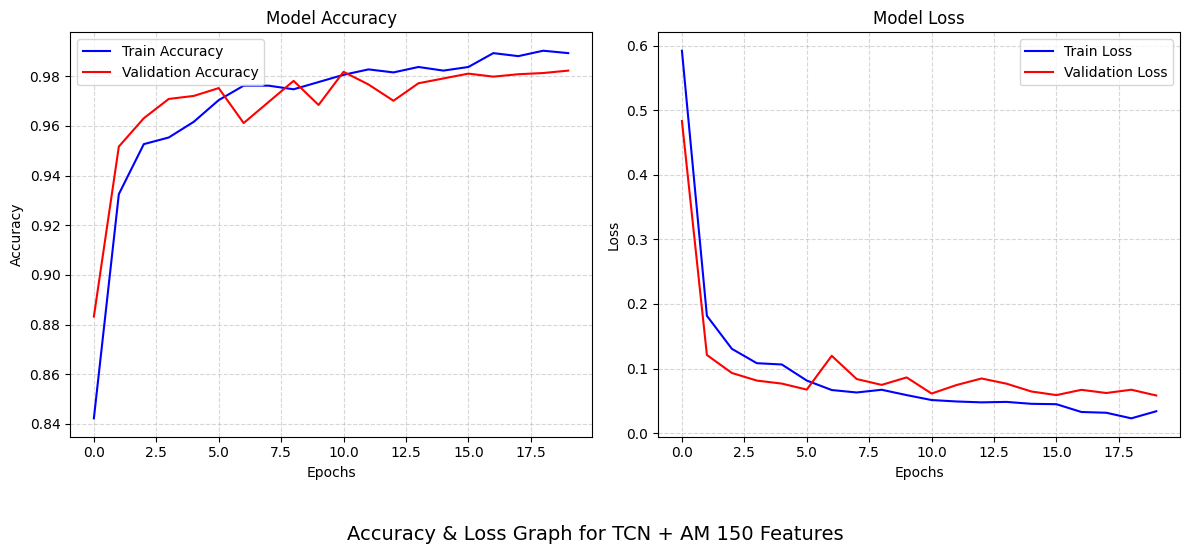

In [6]:
# Set white background
plt.style.use('default')

# Plot Accuracy & Loss Graph
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()

# Add text below the graph
plt.figtext(0.5, -0.09, "Accuracy & Loss Graph for TCN + AM 150 Features", ha="center", fontsize=14)

plt.show()


In [ ]:
from graphviz import Digraph
from IPython.display import Image

def visualize_tcn_model():
    dot = Digraph(format='png')
    dot.attr(rankdir='LR') 
    # Input layer
    dot.node('Input', 'Input Layer\n(150, 1)', shape='box', style='filled', fillcolor='lightblue')
    
    # Residual Blocks
    dot.node('RB1', 'Residual Block 1\n(64 filters, d=1)', shape='box', style='filled', fillcolor='lightcoral')
    dot.node('RB2', 'Residual Block 2\n(64 filters, d=2)', shape='box', style='filled', fillcolor='lightcoral')
    dot.node('RB3', 'Residual Block 3\n(64 filters, d=4)', shape='box', style='filled', fillcolor='lightcoral')
    
    # Attention Mechanism
    dot.node('Attn', 'Attention Mechanism', shape='diamond', style='filled', fillcolor='gold')
    
    # Fully Connected Layers
    dot.node('Flatten', 'Flatten', shape='box', style='filled', fillcolor='lightgreen')
    dot.node('Dense1', 'Dense 128 (ReLU)', shape='box', style='filled', fillcolor='lightgreen')
    dot.node('Dropout', 'Dropout (0.3)', shape='box', style='filled', fillcolor='lightgrey')
    dot.node('Output', 'Output Layer\nDense + Softmax', shape='box', style='filled', fillcolor='lightblue')
    
    # Edges
    dot.edge('Input', 'RB1')
    dot.edge('RB1', 'RB2')
    dot.edge('RB2', 'RB3')
    dot.edge('RB3', 'Attn')
    dot.edge('Attn', 'Flatten')
    dot.edge('Flatten', 'Dense1')
    dot.edge('Dense1', 'Dropout')
    dot.edge('Dropout', 'Output')
    
    return dot

# Render and visualize the model
model_diagram = visualize_tcn_model()
model_diagram.render('tcn_model', view=True)
model_diagram

# Generate and render the model diagram
model_diagram = visualize_tcn_model()
model_diagram.render('tcn_model', format='png')

# Display the generated PNG
Image('tcn_model.png')

In [ ]:
from graphviz import Digraph
from IPython.display import Image

def visualize_tcn_model():
    dot = Digraph(format='png')
    
    # Input layer
    dot.node('Input', 'Input Layer\n(150, 1)', shape='box', style='filled', fillcolor='lightblue')
    
    # Residual Blocks
    dot.node('RB1', 'Residual Block 1\n(64 filters, d=1)', shape='box', style='filled', fillcolor='lightcoral')
    dot.node('RB2', 'Residual Block 2\n(64 filters, d=2)', shape='box', style='filled', fillcolor='lightcoral')
    dot.node('RB3', 'Residual Block 3\n(64 filters, d=4)', shape='box', style='filled', fillcolor='lightcoral')
    
    # Attention Mechanism
    dot.node('Attn', 'Attention Mechanism', shape='diamond', style='filled', fillcolor='gold')
    
    # Fully Connected Layers
    dot.node('Flatten', 'Flatten', shape='box', style='filled', fillcolor='lightgreen')
    dot.node('Dense1', 'Dense 128 (ReLU)', shape='box', style='filled', fillcolor='lightgreen')
    dot.node('Dropout', 'Dropout (0.3)', shape='box', style='filled', fillcolor='lightgrey')
    dot.node('Output', 'Output Layer\nDense + Softmax', shape='box', style='filled', fillcolor='lightblue')
    
    # Edges
    dot.edge('Input', 'RB1')
    dot.edge('RB1', 'RB2')
    dot.edge('RB2', 'RB3')
    dot.edge('RB3', 'Attn')
    dot.edge('Attn', 'Flatten')
    dot.edge('Flatten', 'Dense1')
    dot.edge('Dense1', 'Dropout')
    dot.edge('Dropout', 'Output')
    
    return dot

# Generate and render the model diagram
model_diagram = visualize_tcn_model()
model_diagram.render('tcn_model', format='png')

# Display the generated PNG
Image('tcn_model.png')


# Features used for model training: 150
# Model Test Accuracy: 0.9874
# Precision: 0.9874
# Recall (Sensitivity): 0.9874
# Specificity: 0.9880
# F1-Score: 0.9874
# ROC AUC: 0.9996
# Training Time (Best Model): 41.15 seconds
# Inference Time: 2.06 seconds

# 256 TCN + AM 

In [3]:
# ✅ Import Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, Dropout, ReLU, Flatten, Add, Dense,
    GlobalAveragePooling1D, Multiply, Reshape
)
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,
    roc_auc_score
)
import time
import matplotlib.pyplot as plt
from tqdm import tqdm  # Progress bar

# ✅ Load Dataset
df = pd.read_csv('/kaggle/input/har-dataset/Human_Activity_Recognition_Using_Smartphones_Data.csv')

# Encode target labels
label_encoder = LabelEncoder()
df['Activity'] = label_encoder.fit_transform(df['Activity'])

# Separate features and target
X = df.drop(columns=['Activity']).values
y = df['Activity'].values

# ✅ Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ✅ Feature Selection using LASSO
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_scaled, y)

# Extract absolute coefficients from the best alpha model
feature_importance = np.abs(lasso.coef_)

# Select non-zero features
selected_features_idx = np.where(feature_importance > 0)[0]
X_selected = X_scaled[:, selected_features_idx]

# ✅ Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# ✅ Reshape for Bi-TCN Input
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# ✅ Define Attention Mechanism
def attention_block(inputs):
    """Attention Mechanism"""
    avg_pool = GlobalAveragePooling1D()(inputs)
    dense1 = Dense(units=inputs.shape[-1], activation="relu")(avg_pool)
    dense2 = Dense(units=inputs.shape[-1], activation="sigmoid")(dense1)
    attention = Multiply()([inputs, Reshape((1, inputs.shape[-1]))(dense2)])
    return attention

# ✅ Define Bi-TCN Residual Block with Dilated Convolutions
def residual_block(x, filters, dilation_rate):
    """Bi-TCN Residual Block"""
    conv1 = Conv1D(filters=filters, kernel_size=3, padding='causal', dilation_rate=dilation_rate)(x)
    bn1 = BatchNormalization()(conv1)
    relu1 = ReLU()(bn1)
    dropout1 = Dropout(0.3)(relu1)

    conv2 = Conv1D(filters=filters, kernel_size=3, padding='causal', dilation_rate=dilation_rate)(dropout1)
    bn2 = BatchNormalization()(conv2)
    relu2 = ReLU()(bn2)

    # Residual Connection
    res = Add()([x, relu2])
    return res

# ✅ Cross-validation setup
kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
best_accuracy = 0
best_model = None
best_training_time = None

# ✅ Cross-validation loop
with tqdm(total=kf.get_n_splits(), desc="Running Cross-Validation", unit="split") as pbar:
    for train_index, val_index in kf.split(X_train, y_train):
        X_tr, X_val = X_train[train_index], X_train[val_index]
        y_tr, y_val = y_train[train_index], y_train[val_index]

        # ✅ Define Bi-TCN + AM Model
        input_layer = Input(shape=(X_train.shape[1], 1))
        
        # Bi-TCN Residual Blocks with Dilated Convolutions
        res_block1 = residual_block(input_layer, filters=64, dilation_rate=1)
        res_block2 = residual_block(res_block1, filters=64, dilation_rate=2)
        res_block3 = residual_block(res_block2, filters=64, dilation_rate=4)

        # ✅ Attention Mechanism
        attention_output = attention_block(res_block3)

        flatten = Flatten()(attention_output)
        dense1 = Dense(128, activation='relu')(flatten)
        dropout2 = Dropout(0.3)(dense1)
        output_layer = Dense(len(np.unique(y)), activation='softmax')(dropout2)

        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        # ✅ Train the model and track training time
        start_train_time = time.time()
        history = model.fit(X_tr, y_tr, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=0)
        training_time = time.time() - start_train_time

        # ✅ Evaluate the model
        val_accuracy = model.evaluate(X_val, y_val, verbose=0)[1]
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model = model
            best_training_time = training_time

        pbar.update(1)  # Update progress bar

# ✅ Evaluate the best model
start_time = time.time()
y_pred_prob = best_model.predict(X_test)
inference_time = time.time() - start_time
y_pred = np.argmax(y_pred_prob, axis=1)

# ✅ Metrics Calculation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(tf.keras.utils.to_categorical(y_test), y_pred_prob, multi_class='ovr')

# ✅ Specificity Calculation
specificity = np.mean(np.diag(cm) / np.sum(cm, axis=1))

# ✅ Print Model Summary
print("\nBest Model Architecture Summary:")
best_model.summary()

# ✅ Print Metrics
print(f"Selected Features for Training: {len(selected_features_idx)}")
print(f"Model Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Training Time (Best Model): {best_training_time:.2f} seconds")
print(f"Inference Time: {inference_time:.2f} seconds")


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.4715793535466446, tolerance: 2.3708384755431475
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4371649169875127, tolerance: 2.3708384755431475
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.242961598722445, tolerance: 2.3708384755431475
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: Convergen

65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step

Best Model Architecture Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 1)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_6 (Conv1D)         │ (None, 256, 64)        │            256 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 256, 64)        │            256 │ conv1d_6[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_6 (ReLU)            │ (None, 256, 64)        │              0 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 256, 64)        │              0 │ re_lu_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_7 (Conv1D)         │ (None, 256, 64)        │         12,352 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 256, 64)        │            256 │ conv1d_7[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_7 (ReLU)            │ (None, 256, 64)        │              0 │ batch_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 256, 64)        │              0 │ input_layer_1[0][0],   │
│                           │                        │                │ re_lu_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_8 (Conv1D)         │ (None, 256, 64)        │         12,352 │ add_3[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 256, 64)        │            256 │ conv1d_8[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_8 (ReLU)            │ (None, 256, 64)        │              0 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 256, 64)        │              0 │ re_lu_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_9 (Conv1D)         │ (None, 256, 64)        │         12,352 │ dropout_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9     │ (None, 256, 64)        │            256 │ conv1d_9[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_9 (ReLU)            │ (None, 256, 64)        │              0 │ batch_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_4 (Add)          

 Total params: 6,508,244 (24.83 MB)

 Trainable params: 2,169,158 (8.27 MB)

 Non-trainable params: 768 (3.00 KB)

 Optimizer params: 4,338,318 (16.55 MB)

Selected Features for Training: 256
Model Test Accuracy: 0.9811
Precision: 0.9812
Recall (Sensitivity): 0.9811
Specificity: 0.9815
F1-Score: 0.9811
ROC AUC: 0.9996
Training Time (Best Model): 33.29 seconds
Inference Time: 1.75 seconds


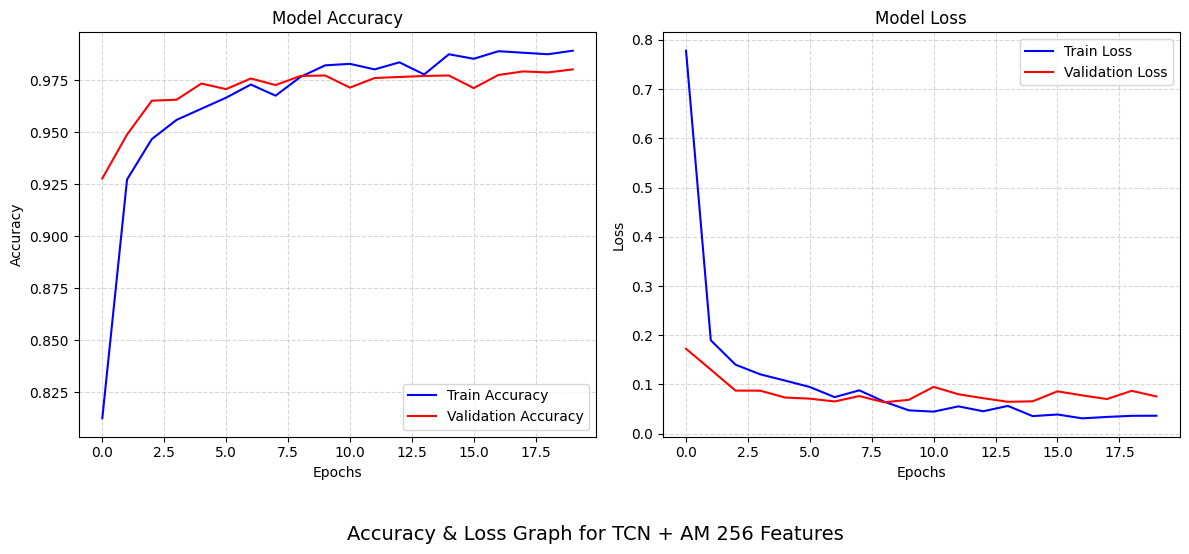

In [4]:
# ✅ Set white background
plt.style.use('default')

# ✅ Plot Accuracy & Loss Graph
plt.figure(figsize=(12, 5))

# ✅ Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue', )
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red', )
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# ✅ Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue', )
plt.plot(history.history['val_loss'], label='Validation Loss', color='red',)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()

# ✅ Add text below the graph
plt.figtext(0.5, -0.09, "Accuracy & Loss Graph for TCN + AM 256 Features", ha="center", fontsize=14)

plt.show()
